* Download, first open file, import data

In [1]:
!pip install googledrivedownloader
!pip install ts2vg
!pip install json2html

import numpy as np
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import math
from google_drive_downloader import GoogleDriveDownloader as gdd

home_dir = '/content'
filename = 'QA-DS-TASK-DATA-FROM-2020-REDUCED-COLUMNS.csv'
link = 'https://drive.google.com/file/d/1i4FGu5pNU8AZ-EE1LwT58UdVLqRuT-K6/view?usp=sharing'
os.chdir(home_dir)

gdd.download_file_from_google_drive(file_id=link.split('/')[-2],
                                    dest_path='./' + filename,
                                    unzip=True)

df = pd.read_csv(filename, parse_dates=['Timestamp'])
print(filename, ' len:', len(df))
print(df.head())

fts_names = df['Ticker Full Name'].unique()
print(fts_names)

df.sort_values('Timestamp', inplace=True)
df.dropna(how='any', axis=0, inplace=True)

dfs = []
for i in range(len(fts_names)):
  dfs.append(df[(df['Ticker Full Name'] == fts_names[i])])
  dfs[i].sort_values('Timestamp', inplace=True)
  dfs[i].reset_index(drop=True, inplace=True)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.9 MB/s 
Unzipping...

/usr/local/lib/python3.7/dist-packages/google_drive_downloader/google_drive_downloader.py:78: UserWarning: Ignoring `unzip` since "1i4FGu5pNU8AZ-EE1LwT58UdVLqRuT-K6" does not look like a valid zip file
  warnings.warn('Ignoring `unzip` since "{}" does not look like a valid zip file'.format(file_id))


QA-DS-TASK-DATA-FROM-2020-REDUCED-COLUMNS.csv  len: 1756857
            Timestamp  Close Candle               Ticker Full Name
0 2020-01-01 18:01:00       128.312  10 YEAR TREASURY NOTE FUTURES
1 2020-01-01 18:02:00       128.312  10 YEAR TREASURY NOTE FUTURES
2 2020-01-01 18:03:00       128.312  10 YEAR TREASURY NOTE FUTURES
3 2020-01-01 18:04:00       128.312  10 YEAR TREASURY NOTE FUTURES
4 2020-01-01 18:05:00       128.328  10 YEAR TREASURY NOTE FUTURES
['10 YEAR TREASURY NOTE FUTURES' 'E-MINI S&P 500 FUTURES'
 'FTSE CHINA A50 INDEX FUTURES']


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


* Remove background with EMA200
* Normalising in range [0,1]

In [2]:
# Normalisation in range [0, 1] closure values
for i in range(len(dfs)):  
  dfs[i]['EMA200'] = np.array(dfs[i]['Close Candle'].ewm(span=2000, adjust=False).mean())
  dfs[i]['Close Candle'] -= dfs[i]['EMA200']
  loc_min, loc_max = dfs[i]['Close Candle'].min(), dfs[i]['Close Candle'].max()
  dfs[i]['Close Candle'] = (dfs[i]['Close Candle'] - loc_min) / (loc_max-loc_min)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

* Sort to easy indexing
* Remove rows with more then 2 NaN values
* Make new dataframe
* ~ 1min execution time

In [3]:
dates_all_in = df['Timestamp'].unique()
min_date = dt.datetime.utcfromtimestamp(int(dates_all_in.min())/1e9)
max_date = dt.datetime.utcfromtimestamp(int(dates_all_in.max())/1e9)
step_date = dt.timedelta(minutes=1)
print(min_date, max_date)

len_date = (int)((max_date - min_date)/step_date) + 1
dates_all = [min_date + step_date * i for i in range(len_date)]
print(len(dates_all))

closes = np.full((len(fts_names),len_date), np.nan)
for i in range(len(fts_names)):
  for j in range(len( dfs[i]['Timestamp'])):
    ind = (int)((dfs[i]['Timestamp'][j]-min_date)/step_date)
    closes[i, ind] = dfs[i]['Close Candle'][j]

d = {'Timestamp': dates_all}
for i in range(len(fts_names)):
  d[fts_names[i]] = closes[i]

dff = pd.DataFrame(data=d)
print(dff.head())

print(len(dff))
dff_filt = dff.dropna(thresh = 2)
dff_filt['Index'] = range(len(dff_filt))
dff_filt.reset_index(drop=True, inplace=True)
print(len(dff_filt))

2020-01-01 18:01:00 2021-11-30 23:59:00
1006919
            Timestamp  10 YEAR TREASURY NOTE FUTURES  E-MINI S&P 500 FUTURES  \
0 2020-01-01 18:01:00                       0.432130                0.596715   
1 2020-01-01 18:02:00                       0.432130                0.592694   
2 2020-01-01 18:03:00                       0.432130                0.594038   
3 2020-01-01 18:04:00                       0.432130                0.596051   
4 2020-01-01 18:05:00                       0.434541                0.594712   

   FTSE CHINA A50 INDEX FUTURES  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  
1006919
684436


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


* Draw closing prices for futures

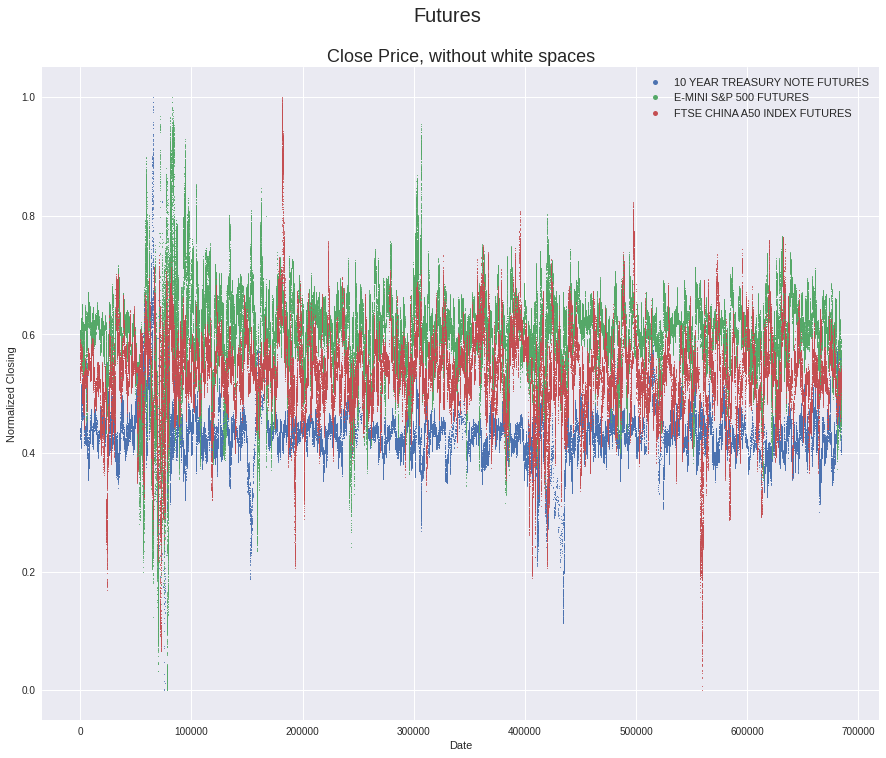

In [4]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Futures", fontsize=20)
st.set_y(0.95)

ax1 = fig.add_subplot(111)
for i in range(len(fts_names)):
  ax1.plot(dff_filt['Index'], dff_filt[fts_names[i]], '.', markersize=2, markeredgewidth=0, label=fts_names[i])

ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing')
ax1.set_title("Close Price, without white spaces", fontsize=18)
ax1.legend(loc="best", markerscale=5., fontsize=11)

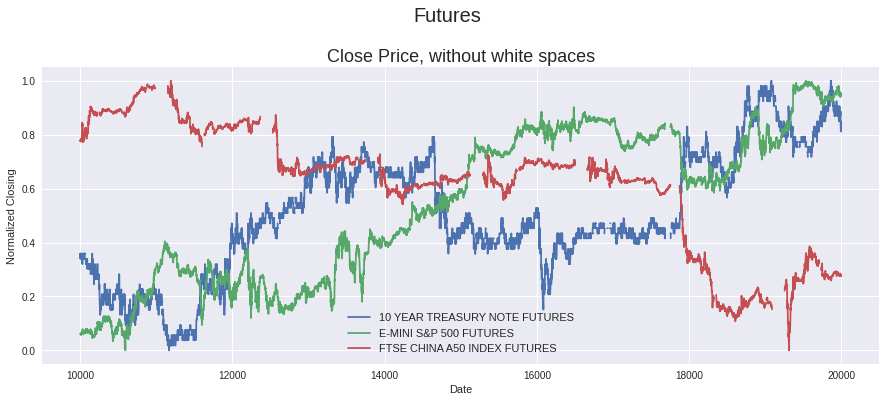

In [157]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Futures", fontsize=20)
st.set_y(0.95)

#prepare sub_massive tu fast watch
# sub_arr = pd.DataFrame(data = dff_filt)
sub_arr = dff_filt[10000:20000].copy()
for i in range(len(dfs)):  
  # dfs[i]['EMA200'] = np.array(dfs[i]['Close Candle'].ewm(span=2000, adjust=False).mean())
  # dfs[i]['Close Candle'] -= dfs[i]['EMA200']
  loc_min, loc_max = sub_arr[[i for i in fts_names]].min(), sub_arr[[i for i in fts_names]].max()
  sub_arr[[i for i in fts_names]] -= loc_min
  sub_arr[[i for i in fts_names]] /= (loc_max-loc_min) 

# sub_arr['Index'] = range(len(sub_arr))

ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)
for i in range(len(fts_names)):
  ax1.plot(sub_arr['Index'], sub_arr[fts_names[i]], '-', markersize=2, markeredgewidth=0, label=fts_names[i])

ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing')
ax1.set_title("Close Price, without white spaces", fontsize=18)
ax1.legend(loc="best", markerscale=5., fontsize=11)

* Core algorithm for searching lags, particaly based on [paper](https://www.researchgate.net/publication/349656577_Detecting_time_lag_between_a_pair_of_time_series_using_visibility_graph_algorithm), using  Visibility Graph Algorithm

In [5]:
from ts2vg import NaturalVG
import random
from scipy.ndimage.interpolation import shift
from numpy import linalg as LA
from scipy.signal import find_peaks

def lag_processing(df, search):
  print(search)

  norm = []  
  window_len = (int)(search['window_len'])
  start = (int)(search['start']*len(df))
  stop = (int)(search['stop']*len(df))
  step = (int)(search['step'])
  dir = (int)(search['dir'])
  lag_limit_devider = search['lag_limit_devider']
  lag_step_devider = search['lag_step_devider']
  array_fullnes = (int)(search['array_fullnes'])

  step2 = (int)(window_len/lag_step_devider)
  lim2 = (int)(window_len/lag_limit_devider)

  ts1 = df[search['first']].to_numpy()
  ts2 = df[search['second']].to_numpy()

  for i in range(start, stop, step):
    tmp_norm = []
    mas_i = ts1[0+i:window_len+i:array_fullnes]
    # make VG
    g = NaturalVG()
    g.build(mas_i)
    # prevent not full lenght readed
    if len(mas_i) < (int)(window_len/array_fullnes):
      # norm.append(np.full((int)(window_len/array_fullnes), np.nan))  
      continue
    # counts non-nan
    n_nan = len(mas_i) - np.count_nonzero(np.isnan(mas_i)) 
    if n_nan/len(mas_i) < 0.3:
      norm.append(np.full((int)(window_len/array_fullnes), np.nan)) 
      continue
    print('mas_i', np.shape(mas_i), i,'/', stop)
    # calc adjacency matrix for graph
    am1 = g.adjacency_matrix(triangle='lower')    
    
    # calc Frobenius norm for difference lag for selected window
    for j in range(-lim2, lim2, step2):   
      t = dir*ts2[0+i+j:window_len+i+j:array_fullnes]
      if window_len+i+j > len(df[fts_names[1]]):
        t = np.full(len(mas_i) - len(t), np.nan)        
      if len(mas_i) > len(t):
        t = np.append(t, np.full(len(mas_i) - len(t), np.nan))
      # counts non-nan
      n_nan = len(t) - np.count_nonzero(np.isnan(t))
      if n_nan/len(t) < 0.3:
        tmp_norm.append(np.nan)
        continue;
      # make VG
      g.build(t)
      # calc adjacency matrix
      ami = g.adjacency_matrix(triangle='lower')   
      # calc Frobenius norm 
      tmp_norm.append(LA.norm(am1 - ami))
    tmp_norm = np.array(tmp_norm)
    tmp_norm_max = np.nanmax(tmp_norm)
    tmp_norm_min = np.nanmin(tmp_norm)
    tmp_norm = (tmp_norm - tmp_norm_min)/(tmp_norm_max-tmp_norm_min)
    norm.append(tmp_norm)    
    print('norm shape:', np.shape(norm))
  norm = np.array(norm)

  # search peaks for  make more contrast picture of lags
  norm_contrast = []
  for i in range(len(norm)):
    std = np.nanstd(norm[i])
    peaks, properties = find_peaks(-norm[i], prominence=(0.2*std, 20*std))
    tmp2 = np.full(len(norm[i]), np.nan)
    tmp2[peaks] = 1
    norm_contrast.append(tmp2)

  norm_contrast = np.array(norm_contrast)
  print('\nnorm shape finaly:', np.shape(norm))
  print('\nnorm_contrast shape finaly:', np.shape(norm_contrast))

  return norm, norm_contrast

* Make search lag configuration
* Execute main searching cycle
* ~20 min to execute with default params

In [27]:
lag_searchs = [{'name':'0-1', 'first':fts_names[0], 'second':fts_names[1], 'dir': -1, 
                'window_len':150000, 'start':0.0, 'stop':1.0, 'step':5000, 
                'lag_limit_devider': 1.0, 'lag_step_devider': 50, 'array_fullnes':50,
                'status':True}, 
              {'name':'0-2', 'first':fts_names[0], 'second':fts_names[2], 'dir': -1, 
               'window_len':150000, 'start':0.0, 'stop':1.0, 'step':5000, 
               'lag_limit_devider': 1.0, 'lag_step_devider': 50, 'array_fullnes':50,
               'status':True},
              {'name':'1+2', 'first':fts_names[1], 'second':fts_names[2], 'dir':  1, 
               'window_len':150000, 'start':0.0, 'stop':1.0, 'step':5000, 
               'lag_limit_devider': 1.0, 'lag_step_devider': 50, 'array_fullnes':50,
               'status':True}]

results = []
for search in lag_searchs:
  if not search['status']: continue
  norms, peaks = lag_processing(dff_filt, search)
  results.append((norms, peaks, search))
 

{'name': '0-1', 'first': '10 YEAR TREASURY NOTE FUTURES', 'second': 'E-MINI S&P 500 FUTURES', 'dir': -1, 'window_len': 150000, 'start': 0.0, 'stop': 1.0, 'step': 5000, 'lag_limit_devider': 1.0, 'lag_step_devider': 50, 'array_fullnes': 50, 'status': True}
mas_i (3000,) 0 / 684436
norm shape: (1, 100)
mas_i (3000,) 5000 / 684436
norm shape: (2, 100)
mas_i (3000,) 10000 / 684436
norm shape: (3, 100)
mas_i (3000,) 15000 / 684436
norm shape: (4, 100)
mas_i (3000,) 20000 / 684436
norm shape: (5, 100)
mas_i (3000,) 25000 / 684436
norm shape: (6, 100)
mas_i (3000,) 30000 / 684436
norm shape: (7, 100)
mas_i (3000,) 35000 / 684436
norm shape: (8, 100)
mas_i (3000,) 40000 / 684436
norm shape: (9, 100)
mas_i (3000,) 45000 / 684436
norm shape: (10, 100)
mas_i (3000,) 50000 / 684436
norm shape: (11, 100)
mas_i (3000,) 55000 / 684436
norm shape: (12, 100)
mas_i (3000,) 60000 / 684436
norm shape: (13, 100)
mas_i (3000,) 65000 / 684436
norm shape: (14, 100)
mas_i (3000,) 70000 / 684436
norm shape: (15,

* Drawing norms and peaks, peak searching may be modified inside searching peak func

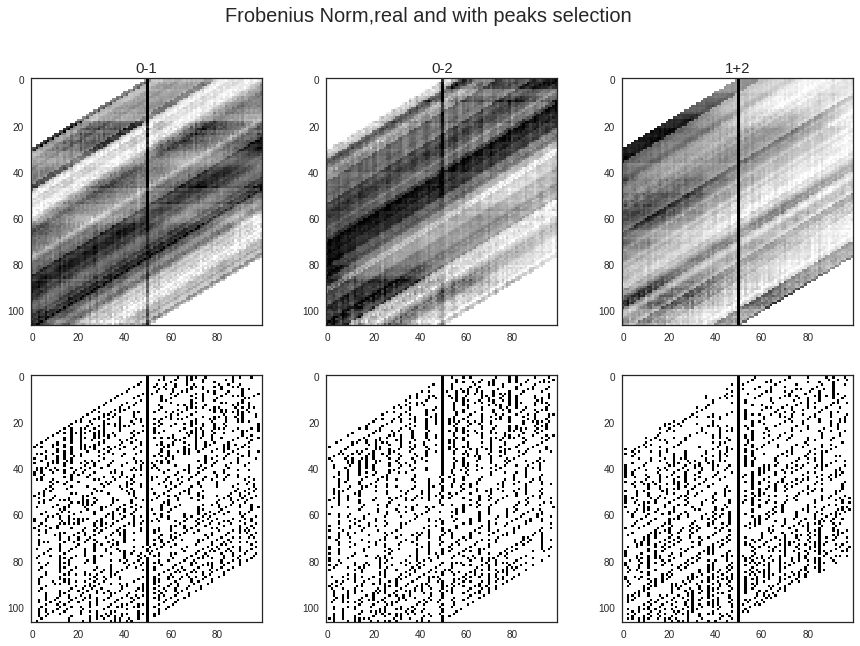

In [30]:
plt.style.use('seaborn-white')
# f = plt.figure(figsize=(15,5))
f = plt.figure(figsize=(15,10))
st = f.suptitle("Frobenius Norm,real and with peaks selection", fontsize=20)
plt.gray()

res_ctr = 0
for result in results: 
  norms, peaks, search = result  
  f.add_subplot(2, len(results), 1+res_ctr)
  plt.gca().set_title(search['name'],  fontsize=15)
  plt.imshow(norms, interpolation='None')
  f.add_subplot(2, len(results), 1+len(results)+res_ctr)
  plt.imshow(peaks, interpolation='None')
  res_ctr += 1
plt.show()

* **Not necessary to execute**
* Prepare output file with data and lag searching results

In [18]:
df_new = dff_filt.copy()
for norms, peaks, search in results:
  prev = np.full(len(peaks[0]), np.nan)
  lags = []
  for i in range(len(peaks)):
    lags_cur = []
    for j in range(len(peaks[0])):
      if peaks[i,j] > 0.99 and prev[j] == peaks[i,j]:
        lags_cur.append([(j-len(peaks[0])/2)*search['window_len']/search['lag_step_devider'], (-norms[i,j]+0.5)*2])
    prev = peaks[i]
    lags.append(lags_cur)
  
  print(np.shape(lags))
  lags_full = [[] for i in range(len(dff_filt))]
  for i in range(len(lags)):
    # to save more space
    # ind = (int)(i*search['step'] + len(dff_filt)*search['start'] + j)
    # if ind < len(dff_filt) and ind < len(dff_filt)*search['stop'] :
    #   lags_full[ind] = lags[i]

    for j in range(search['step']):
      ind = (int)(i*search['step'] + len(dff_filt)*search['start'] + j)
      if ind < len(dff_filt) and ind < len(dff_filt)*search['stop'] :
        lags_full[ind] = lags[i]
  df_new[search['name']] = lags_full

print(df_new.head())
df_new.to_csv('df_new.csv', index=False)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(171,)
(171,)
(171,)
            Timestamp  10 YEAR TREASURY NOTE FUTURES  E-MINI S&P 500 FUTURES  \
0 2020-01-01 18:01:00                       0.432130                0.596715   
1 2020-01-01 18:02:00                       0.432130                0.592694   
2 2020-01-01 18:03:00                       0.432130                0.594038   
3 2020-01-01 18:04:00                       0.432130                0.596051   
4 2020-01-01 18:05:00                       0.434541                0.594712   

   FTSE CHINA A50 INDEX FUTURES  Index 0-1 0-2 1+2  
0                           NaN      0  []  []  []  
1                           NaN      1  []  []  []  
2                           NaN      2  []  []  []  
3                           NaN      3  []  []  []  
4                           NaN      4  []  []  []  


* Prepare HTML output file

In [31]:
import json2html

lags_full = {'searches':[]}
for norms, peaks, search in results:
  prev = np.full(len(peaks[0]), np.nan)
  lags = []
  for i in range(len(peaks)):
    lags_cur = []
    for j in range(len(peaks[0])):
      if peaks[i,j] > 0.99 and prev[j] == peaks[i,j]:
        ind = (int)(i*search['step'] + len(dff_filt)*search['start'])
        if ind < len(dff_filt):
          # print(ind)
          lags_cur.append({'lag':(j-len(peaks[0])/2)*search['window_len']/search['lag_step_devider'],
                          'power':(-norms[i,j]+0.5)*2})
    prev = peaks[i]
    lags.append({'time':dff_filt['Timestamp'][ind], 'lags': lags_cur})
  lags_full['searches'].append({'name':search['name'],
                                'search_params': search,
                                'results':lags})  

html = json2html.json2html.convert(json = lags_full)
with open('lags_long.html', 'a') as o:
    o.write(html)